http://intelligence.korea.ac.kr/members/wschoi/seminar/tutorial/mnist/pytorch/gan/GAN-%ED%8A%9C%ED%86%A0%EB%A6%AC%EC%96%BC/

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

In [2]:
# standardization code
standardizator = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5,),   # 3 for RGB channels이나 실제론 gray scale
                                         std=(0.5, ))])  # 3 for RGB channels이나 실제론 gray scale

# MNIST dataset
train_data = dsets.MNIST(root='data/', train=True, transform=standardizator, download=True)
test_data  = dsets.MNIST(root='data/', train=False, transform=standardizator, download=True)


batch_size = 200
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

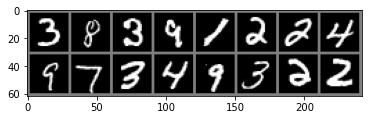

In [10]:
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img+1)/2    
    img = img.squeeze() # tensor의 차원을 줄여줌 차원 늘리기 -> unsqueeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img): 
    # 이미지 출력을 위해 cpu에 담고 추적 방지
    img = utils.make_grid(img.cpu().detach()) 
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0))) #  C*H*W -> H*W*C
    plt.show()
    
example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

iterator 객체 - 값을 차례대로 꺼낼 수 있는 객체
iter() 함수를 사용해 iterator 객체를 만들 수 있다.
next() 함수를 사용해 첫번째, 두번째, 세번재 값이 출력된다.

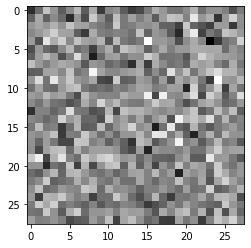

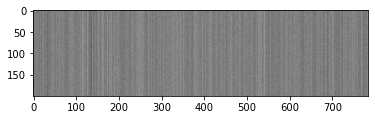

In [4]:
d_noise  = 100
d_hidden = 256

def sample_z(batch_size = 1, d_noise=100):
    return torch.randn(batch_size, d_noise, device=device)

G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 28*28),
    nn.Tanh()
).to(device)

# 노이즈 생성하기
z = sample_z()
# 가짜 이미지 생성하기
img_fake = G(z).view(-1,28,28) # (200,28,28)
# 이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

# Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
z = sample_z(batch_size)
img_fake = G(z) # Generator 모델을 통과한 200 batch의 노이즈 벡터 이미지
imshow_grid(img_fake)

In [5]:
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
).to(device)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1)) # 새로운 텐서 반환(행렬 바꾸기) 

torch.Size([200, 784])
torch.Size([200, 1])
tensor([[0.5031, 0.5039, 0.5052, 0.5037, 0.4981]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


<LeakyReLU 함수> <br>
def leakyrelu(z, alpha):
    return max(alpha * z, z)
    
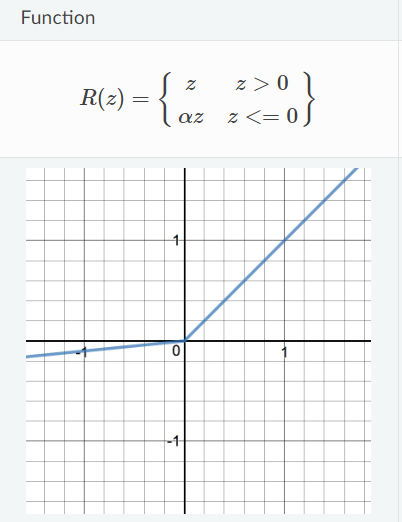

$$ BCELoss(y_^,y) = -(y * log(y_hat)+(1-y)*log(1-y_hat)) $$

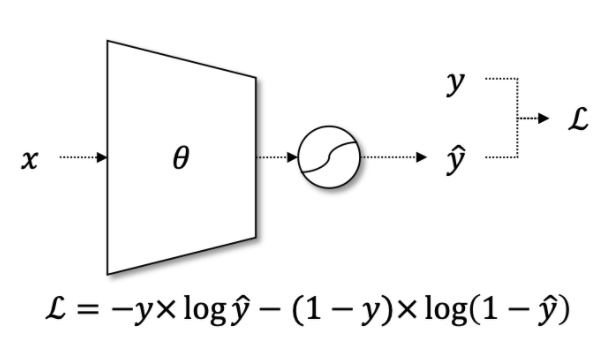

In [6]:
# binary cross entropy loss(BCELoss) : 기존의 교차 엔트로피 손실 함수의 한 케이스
# : 이진 분류에 특화
# BCELoss() 쓰면 마지막 레이어때 시그모이드함수를 적용시켜줘야한다.
criterion = nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    
    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 

        # ================================================  #
        # maximize V(discriminator,generator) = optimize discriminator (setting k to be 1)  #
        # ================================================  #

        # init optimizer
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1, 28*28))
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        # https://t-lab.tistory.com/16
        # -1 비용함수의 값을 극대화시키는 파라미터 값을 점진적으로 찾는 방법
        loss_real = -1 * torch.log(p_real)    
        loss_fake = -1 * torch.log(1.-p_fake) 
        loss_d    = (loss_real + loss_fake).mean()
        
        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + \    #
        #          criterion(p_fake, torch.zeros_like(p_real).to(device))       #
        
        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # ================================================  #
        #        minimize V(discriminator,generator)        #
        # ================================================  #

        # init optimizer
        _optimizer_g.zero_grad()

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))
                
        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        
        # instead of: torch.log(1.-p_fake).mean() <- explained in Section 3
        loss_g = -1 * torch.log(p_fake).mean() 

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) #

        loss_g.backward()
   
        # Update parameters
        _optimizer_g.step()
          
def evaluate_model(generator, discriminator):
    
    p_real, p_fake = 0.,0.
    
    generator.eval()
    discriminator.eval()
        
    for img_batch, label_batch in test_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 
        
        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.
            
            
    return p_real, p_fake

(epoch 50/200) p_real: 0.804420, p_g: 0.284460


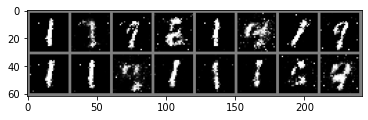

(epoch 100/200) p_real: 0.687812, p_g: 0.333965


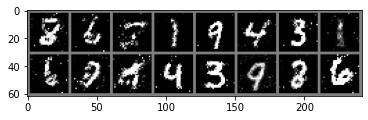

(epoch 150/200) p_real: 0.616051, p_g: 0.316437


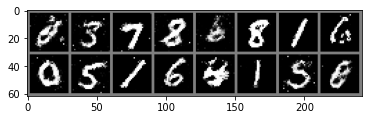

(epoch 200/200) p_real: 0.614129, p_g: 0.288346


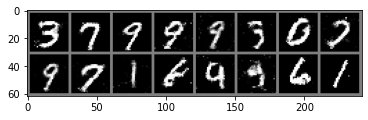

In [7]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = optim.Adam(D.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in range(200):
    
    run_epoch(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)
    
    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake) 
    
    if((epoch+1)% 50 == 0):
        print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
        imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))

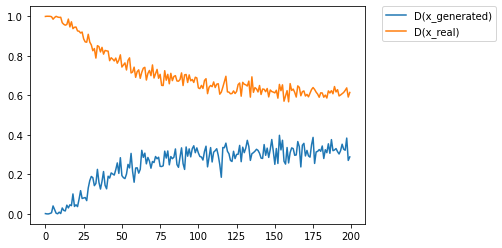

In [8]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

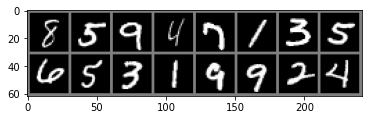

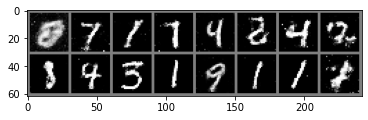

In [9]:
vis_loader = torch.utils.data.DataLoader(test_data, 16, True)
img_vis, label_vis   = next(iter(vis_loader))
imshow_grid(img_vis)

imshow_grid(G(sample_z(16,100)).view(-1, 1, 28, 28))